In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LinearRegression, GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, GridSearchCV

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
from pylab import rcParams

In [4]:
import warnings

In [5]:
%matplotlib inline
warnings.filterwarnings('ignore')

In [6]:
sns.set(rc={'figure.figsize': (10, 8)})
rcParams.update({'font.size': 14})

In [7]:
TRAIN_DATASET_PATH = 'realestatepriceprediction/train.csv'
TEST_DATASET_PATH = 'realestatepriceprediction/test.csv'
PREPARED_TRAIN_DATASET_PATH = 'realestatepriceprediction/prepared_train.csv'
SAMPLE_SUBMISSION_PATH = 'realestatepriceprediction/sample_submission.csv'

### Загрузка данных

#### Описание файлов

- **train.csv** - тренировочный набоp  
- **test.csv** - тестовый набор  
- **sample_submission.csv** - файл с отправкой образца в правильном формате

#### Поля данных

- **Id** - идентификационный номер квартиры  
- **DistrictId** - идентификационный номер района  
- **Rooms** - количество комнат
- **Square** - площадь  
- **LifeSquare** - жилая площадь  
- **KitchenSquare** - площадь кухни  
- **Floor** - этаж  
- **HouseFloor** - количество этажей в доме  
- **HouseYear** - год постройки дома  
- **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности  
- **Social_1, Social_2, Social_3** - социальные показатели местности  
- **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровьем  
- **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров  
- **Price** - цена квартиры

In [8]:
# Создадим датафрейм с тренировочными данными
df = pd.read_csv(TRAIN_DATASET_PATH)
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [9]:
# Сделаем Id индексом
df = df.set_index('Id')
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


### Обзор данных

In [10]:
price_median = df['Price'].median()
price_mean = df['Price'].mean()
price_mode = df['Price'].mode()[0]
price_min = df['Price'].min()
price_max = df['Price'].max()
print('Наименьшее: ', price_min)
print('Наибольшее: ', price_max)
print('Медиана: ', price_median)
print('Среднее: ', price_mean)
print('Мода: ', price_mode)

Наименьшее:  59174.77802758122
Наибольшее:  633233.4665699474
Медиана:  192269.64487934904
Среднее:  214138.85739873844
Мода:  59174.77802758122


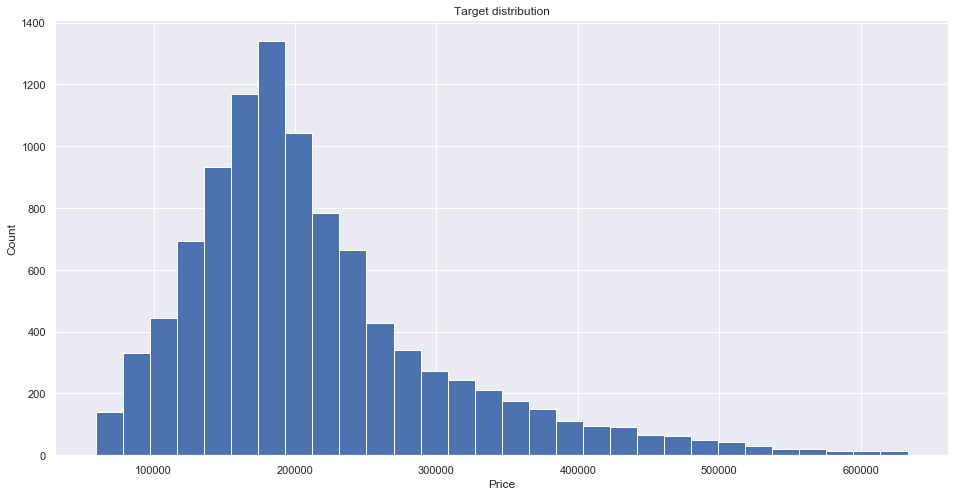

In [11]:
# Посмотрим целевую переменную
plt.figure(figsize=(16, 8))
df['Price'].hist(bins=30)
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Target distribution')

plt.show()

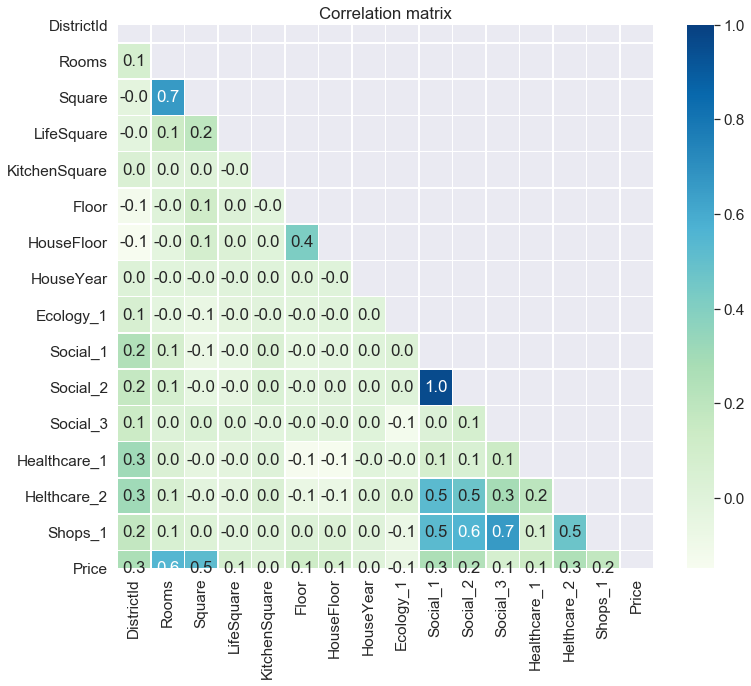

In [12]:
corr = df.corr()
plt.figure(figsize = (12, 10))
mask = np.zeros_like(corr, dtype=np.bool)  # отрезаем лишнюю половину матрицы
mask[np.triu_indices_from(mask)] = True
sns.set(font_scale=1.4)
sns.heatmap(df.corr(), mask=mask, annot=True, fmt='.1f', linewidths=.5, cmap='GnBu')
plt.title('Correlation matrix')
plt.show()

Обратим внимание, что Social_2 и Social_1 имеют корреляцию 1

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1ea47450>,
      dtype=object)

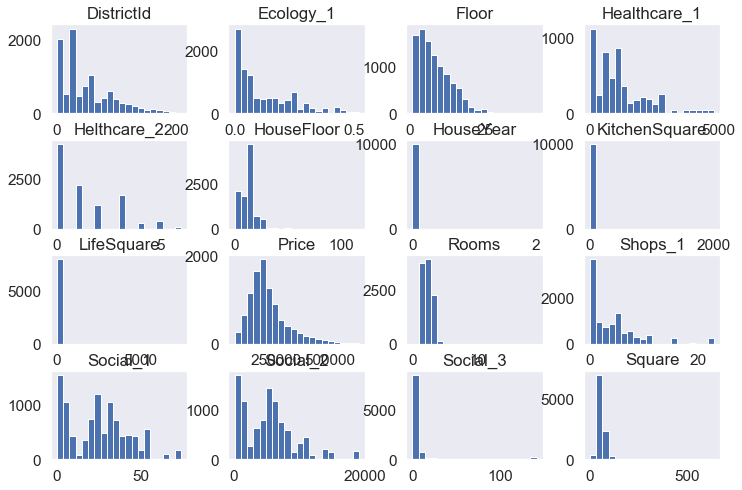

In [13]:
# Посмотрим целевую переменную в разрезе других признаков
df.hist(figsize=(12, 8), bins=20, grid=False)

In [14]:
# Удалим Social_2
df = df.drop('Social_2', axis=1)

In [15]:
# Проверим полноту данных
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 18 columns):
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(7), object(3)
memory usage: 1.4+ MB


In [16]:
# В параметре Healthcare_1 отсутствует почти половина данных и корреляция его с Price всего 0.1. 
# Данный параметр не может быть оценен объективно и оказывает слабое влияние на Price.
# Удалим его
df = df.drop('Healthcare_1', axis=1)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,2.090000e+02
Rooms,10000.0,1.890500,0.839512,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315775,21.058732,1.136859,41.774881,52.513310,65.900625,6.410652e+02
LifeSquare,7887.0,37.199645,86.241209,0.370619,22.769832,32.781260,45.128803,7.480592e+03
KitchenSquare,10000.0,6.273300,28.560917,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.775974,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218671e-01
Social_1,10000.0,24.687000,17.532614,0.000000,6.000000,25.000000,36.000000,7.400000e+01


У нас не полные данные LifeSquare. Не хватает примерно трети. Это значительное количество. Проверим достоверность данных, чтобы принять решение - удалить данные или дополнить. Для этого найдем недостоверные данные:  
1. LifeSquare > Square  
2. LifeSquare > max Square
3. LifeSquare < 10

In [17]:
df.loc[(df['LifeSquare'] > df['Square']) | (df['LifeSquare'] < 10) | (df['LifeSquare'] > 641)].shape

(680, 17)

Еще 680 данных недостоверны. Когда треть данных отсутствует или недостоверна лучше их не использовать. Кроме того корреляция с Price 0.1. Удалим LifeSquare.

In [18]:
df = df.drop('LifeSquare', axis=1)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,2.090000e+02
Rooms,10000.0,1.890500,0.839512,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315775,21.058732,1.136859,41.774881,52.513310,65.900625,6.410652e+02
KitchenSquare,10000.0,6.273300,28.560917,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.775974,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218671e-01
Social_1,10000.0,24.687000,17.532614,0.000000,6.000000,25.000000,36.000000,7.400000e+01
Social_3,10000.0,8.039200,23.831875,0.000000,0.000000,2.000000,5.000000,1.410000e+02


#### Обработаем выбросы

In [19]:
# Рассмотрим квартиры с Square меньше 10
df.loc[df['Square']  < 10]

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_3,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,
1748,88,2.0,5.497061,1.0,24,22.0,1977,0.127376,B,B,43,3,3,9,B,412511.088764
11526,27,1.0,4.633498,1.0,18,1.0,1977,0.011654,B,B,4,0,0,0,B,107604.269441
10202,6,1.0,2.596351,1.0,3,25.0,2014,0.243205,B,B,5,0,0,0,B,137597.601458
10527,27,1.0,4.380726,1.0,10,17.0,2013,0.211401,B,B,9,0,0,1,B,97560.720383
9487,5,1.0,5.129222,1.0,1,1.0,1977,0.150818,B,B,16,4,4,5,B,369472.403061
3224,27,0.0,2.377248,0.0,1,0.0,1977,0.017647,B,B,2,0,0,0,B,126596.941798
4504,27,3.0,4.390331,1.0,8,19.0,2016,0.211401,B,B,9,0,0,1,B,161379.067034
14786,1,1.0,1.136859,1.0,3,1.0,1977,0.007122,B,B,1,0,0,1,B,181434.825589
13265,1,3.0,4.823679,0.0,6,17.0,1977,0.007122,B,B,1,0,0,1,B,237716.681261


In [20]:
# Нет ни одной Square пригодной для проживания. 
# Предположим, что в данных ошибка в порядке и умножим эти данные на 10.
df.loc[df['Square']  < 10, 'Square'] = df.loc[df['Square']  < 10] * 10

In [21]:
# Проверим
df.loc[df['Square']  < 20]

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_3,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,
13685,0,1.0,17.498542,0.0,7,5.0,1961,0.319809,B,B,25,16,5,8,B,88871.750230
15127,150,1.0,17.046188,8.0,7,12.0,1982,0.300323,B,B,52,6,1,9,B,74222.110465
523,101,1.0,18.509177,3.0,5,5.0,1970,0.225825,A,B,41,7,3,2,B,115845.861527
12676,81,3.0,13.784865,7.0,4,5.0,1960,0.319809,B,B,25,16,5,8,B,78388.806186
15877,57,3.0,16.547242,8.0,5,5.0,1962,0.133215,B,B,49,3,3,4,A,77835.185808
14786,1,1.0,11.368588,1.0,3,1.0,1977,0.007122,B,B,1,0,0,1,B,181434.825589
12927,62,2.0,17.414181,1.0,4,20.0,1977,0.072158,B,B,2,1,0,0,A,180750.471749
6927,21,1.0,16.117154,0.0,2,5.0,1965,0.194489,B,B,47,3,3,5,B,79913.267856
10635,21,1.0,18.983962,2.0,1,5.0,1967,0.194489,B,B,47,3,3,5,B,112411.221700


In [22]:
# Найдем квартиры с площадью комнаты меньше 10
df.loc[((df['Square'] - df['KitchenSquare']) / df['Rooms']) < 10]

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_3,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,
16395,2,3.0,79.722243,72.0,12,16.0,1987,0.130618,B,B,39,9,1,9,B,370148.625285
5927,57,10.0,59.056975,10.0,22,22.0,2002,0.090799,B,B,74,2,5,15,B,317265.323792
1315,6,1.0,48.128114,48.0,21,1.0,2013,0.243205,B,B,5,0,0,0,B,146950.912410
14656,62,1.0,47.100719,2014.0,4,1.0,2014,0.072158,B,B,2,1,0,0,A,108337.484207
9690,27,1.0,40.081042,37.0,18,19.0,2019,0.211401,B,B,9,0,0,1,B,93218.650461
2371,27,2.0,68.841073,66.0,4,2.0,2014,0.017647,B,B,2,0,0,0,B,189244.249909
8491,1,19.0,42.006046,7.0,17,17.0,2014,0.007122,B,B,1,0,0,1,B,78364.616704
12507,54,2.0,79.810535,78.0,10,15.0,2014,0.006076,B,B,30,0,6,6,B,438708.707579
4265,161,2.0,53.216778,53.0,7,17.0,1994,0.000699,B,B,14,24,0,3,B,261125.669724


In [23]:
# Изменим количество комнат на 1
df.loc[((df['Square'] - df['KitchenSquare']) / df['Rooms']) < 10, 'Rooms'] = 1
df.loc[((df['Square'] - df['KitchenSquare']) / df['Rooms']) < 10]

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_3,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,
16395,2,1.0,79.722243,72.0,12,16.0,1987,0.130618,B,B,39,9,1,9,B,370148.625285
1315,6,1.0,48.128114,48.0,21,1.0,2013,0.243205,B,B,5,0,0,0,B,146950.912410
14656,62,1.0,47.100719,2014.0,4,1.0,2014,0.072158,B,B,2,1,0,0,A,108337.484207
9690,27,1.0,40.081042,37.0,18,19.0,2019,0.211401,B,B,9,0,0,1,B,93218.650461
2371,27,1.0,68.841073,66.0,4,2.0,2014,0.017647,B,B,2,0,0,0,B,189244.249909
12507,54,1.0,79.810535,78.0,10,15.0,2014,0.006076,B,B,30,0,6,6,B,438708.707579
4265,161,1.0,53.216778,53.0,7,17.0,1994,0.000699,B,B,14,24,0,3,B,261125.669724
12390,72,1.0,97.490674,96.0,22,25.0,2019,0.210473,B,B,11,2,3,0,B,445074.956552
7441,62,1.0,114.734473,112.0,3,3.0,2015,0.072158,B,B,2,1,0,0,A,315245.521059


In [24]:
# Можно допустить, что комната одна и она совмещена с кухней, поэтому их площади равны или близки по значениюю
# Выберем квартиры, где кухня больше площади.
df.loc[df['Square'] < df['KitchenSquare']]

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_3,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,
14656,62,1.0,47.100719,2014.0,4,1.0,2014,0.072158,B,B,2,1,0,0,A,108337.484207
13703,42,1.0,38.071692,73.0,9,10.0,2006,0.158249,B,B,21,0,1,0,B,160488.033165
6569,27,1.0,38.220258,84.0,4,17.0,2018,0.011654,B,B,4,0,0,0,B,99079.960518
14679,81,1.0,32.276663,1970.0,6,1.0,1977,0.006076,B,B,30,0,6,6,B,105539.556275


In [25]:
# В двух площади кухни явно перепутаны с годами. Заменим их на 0.
# В двух других скорее всего значения площади и кухни перепутаны местами
# Исправим это
df.loc[df['KitchenSquare'] > 1000, 'KitchenSquare'] = 0
df.loc[df['Square'] < df['KitchenSquare']]

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_3,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,
13703,42,1.0,38.071692,73.0,9,10.0,2006,0.158249,B,B,21,0,1,0,B,160488.033165
6569,27,1.0,38.220258,84.0,4,17.0,2018,0.011654,B,B,4,0,0,0,B,99079.960518


In [26]:
a = np.array([df.loc[df['Square'] < df['KitchenSquare'], 'Square']])
a

array([[38.07169235, 38.22025827]])

In [27]:
df.loc[df['Square'] < df['KitchenSquare'], 'Square'] = df['KitchenSquare']
df.loc[df['Square'] == df['KitchenSquare']]

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_3,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,
13703,42,1.0,73.0,73.0,9,10.0,2006,0.158249,B,B,21,0,1,0,B,160488.033165
6569,27,1.0,84.0,84.0,4,17.0,2018,0.011654,B,B,4,0,0,0,B,99079.960518


In [28]:
b, c = a[0, 0], a[0, 1]
df.loc[df['Square'] == df['KitchenSquare'], 'KitchenSquare'] = b, c
# Проверим
df.loc[(df['Square'] == 73) | (df['Square'] == 84)]

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_3,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,
13703,42,1.0,73.0,38.071692,9,10.0,2006,0.158249,B,B,21,0,1,0,B,160488.033165
6569,27,1.0,84.0,38.220258,4,17.0,2018,0.011654,B,B,4,0,0,0,B,99079.960518


In [29]:
# Проверим дома с 0 этажей и этажем квартиры выше, чем этажей в доме
df.loc[(df['HouseFloor'] == 0) | (df['HouseFloor'] < df['Floor'])].shape

(1825, 16)

In [30]:
# Заменим значения HouseFloor на Floor
df.loc[(df['HouseFloor'] == 0) | (df['HouseFloor'] < df['Floor']), 'HouseFloor'] = df['Floor']

In [31]:
# Найдем выбросы в HouseYear
df.loc[df['HouseYear'] > 2019]

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_3,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,
15051,53,2.0,59.597891,10.0,3,24.0,2020,0.049637,B,B,34,0,1,3,B,243114.222804
4345,62,1.0,49.275155,1.0,5,5.0,2020,0.072158,B,B,2,1,0,0,A,135353.885620
6845,169,3.0,87.371123,12.0,4,24.0,2020,0.178917,B,B,18,4,1,5,B,295304.011974
2530,53,2.0,64.233072,13.0,13,24.0,2020,0.049637,B,B,34,0,1,3,B,283334.496716
10814,109,1.0,37.265070,9.0,9,12.0,20052011,0.136330,B,B,30,10,3,6,B,254084.534396
6731,120,2.0,85.087643,10.0,7,10.0,2020,0.341072,B,B,27,48,3,11,B,536020.260344
3445,53,1.0,35.672788,8.0,4,24.0,2020,0.049637,B,B,34,0,1,3,B,170847.416766
8832,1,3.0,83.260743,1.0,15,21.0,2020,0.007122,B,B,1,0,0,1,B,242243.090839
9600,62,1.0,55.911215,10.0,6,17.0,2020,0.072158,B,B,2,1,0,0,A,138770.715048


In [32]:
# Заменим нереальные даты
df.loc[df['HouseYear'] == 20052011, 'HouseYear'] = 2005
df.loc[df['HouseYear'] == 4968, 'HouseYear'] = 1968
df.loc[df['HouseYear'] > 2019]

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_3,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,
15051,53,2.0,59.597891,10.0,3,24.0,2020,0.049637,B,B,34,0,1,3,B,243114.222804
4345,62,1.0,49.275155,1.0,5,5.0,2020,0.072158,B,B,2,1,0,0,A,135353.885620
6845,169,3.0,87.371123,12.0,4,24.0,2020,0.178917,B,B,18,4,1,5,B,295304.011974
2530,53,2.0,64.233072,13.0,13,24.0,2020,0.049637,B,B,34,0,1,3,B,283334.496716
6731,120,2.0,85.087643,10.0,7,10.0,2020,0.341072,B,B,27,48,3,11,B,536020.260344
3445,53,1.0,35.672788,8.0,4,24.0,2020,0.049637,B,B,34,0,1,3,B,170847.416766
8832,1,3.0,83.260743,1.0,15,21.0,2020,0.007122,B,B,1,0,0,1,B,242243.090839
9600,62,1.0,55.911215,10.0,6,17.0,2020,0.072158,B,B,2,1,0,0,A,138770.715048
7026,62,1.0,44.019287,1.0,7,12.0,2020,0.072158,B,B,2,1,0,0,A,135588.215289


In [33]:
# Рассмотрим признаки типа object
df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [34]:
df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [35]:
df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

In [36]:
# Заменим В на 1 и А на 0 и тип на int
df['Ecology_2'] = (df['Ecology_2'] == 'B').astype(int)
df['Ecology_2'].value_counts()

1    9903
0      97
Name: Ecology_2, dtype: int64

In [37]:
df['Ecology_3'] = (df['Ecology_3'] == 'B').astype(int)
df['Ecology_3'].value_counts()

1    9725
0     275
Name: Ecology_3, dtype: int64

In [38]:
df['Shops_2'] = (df['Shops_2'] == 'B').astype(int)
df['Shops_2'].value_counts()

1    9175
0     825
Name: Shops_2, dtype: int64

In [39]:
# Проверим
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 16 columns):
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null int64
Ecology_3        10000 non-null int64
Social_1         10000 non-null int64
Social_3         10000 non-null int64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null int64
Price            10000 non-null float64
dtypes: float64(6), int64(10)
memory usage: 1.6 MB


In [40]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,209.000000
Rooms,10000.0,1.882200,0.811905,0.000000,1.000000,2.000000,2.000000,5.000000
Square,10000.0,56.363816,20.996411,11.368588,41.787090,52.535436,65.912854,641.065193
KitchenSquare,10000.0,5.866829,5.091614,0.000000,1.000000,6.000000,9.000000,123.000000
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,42.000000
HouseFloor,10000.0,13.435700,6.094012,1.000000,9.000000,14.000000,17.000000,117.000000
HouseYear,10000.0,1984.865700,18.411517,1910.000000,1974.000000,1977.000000,2001.000000,2020.000000
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,0.521867
Ecology_2,10000.0,0.990300,0.098015,0.000000,1.000000,1.000000,1.000000,1.000000
Ecology_3,10000.0,0.972500,0.163543,0.000000,1.000000,1.000000,1.000000,1.000000


In [41]:
# Сохраним данные
df.to_csv(PREPARED_TRAIN_DATASET_PATH, index=False, encoding='utf-8')

#### Разделим данные на 2 датафрейма

In [42]:
target = pd.DataFrame(df['Price'], columns=['Price'])
target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 1 columns):
Price    10000 non-null float64
dtypes: float64(1)
memory usage: 476.2 KB


In [43]:
data_columns = df.columns[: -1]
data_columns

Index(['DistrictId', 'Rooms', 'Square', 'KitchenSquare', 'Floor', 'HouseFloor',
       'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1',
       'Social_3', 'Helthcare_2', 'Shops_1', 'Shops_2'],
      dtype='object')

In [44]:
data = df[data_columns]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 15 columns):
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null int64
Ecology_3        10000 non-null int64
Social_1         10000 non-null int64
Social_3         10000 non-null int64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null int64
dtypes: float64(5), int64(10)
memory usage: 1.5 MB


#### Разделим данные на тестовые и тренировочные

In [45]:
y = target
X = data

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=21)
X_train.shape

(7500, 15)

#### Применим модель случайный лес.

In [47]:
rf = RandomForestRegressor(random_state=21)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=21, verbose=0,
                      warm_start=False)

In [48]:
y_predict_train = rf.predict(X_train)
r2_score(y_train, y_predict_train)

0.9447898511028798

In [49]:
y_predict_test = rf.predict(X_test)
r2_score(y_test, y_predict_test)

0.6967580757891882

#### Перекрестная проверка

In [50]:
cv_score = cross_val_score(rf, X, y, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.70646026, 0.68826748, 0.70892029])

In [51]:
cv_score.mean()

0.7012160111610667

#### Важность признаков

In [52]:
feature_importans = pd.DataFrame(zip(X_train.columns, rf.feature_importances_),
                                columns=('Feature name', 'importance'))
feature_importans.sort_values(by='importance', ascending=False)

,Feature name,importance
2,Square,0.408539
10,Social_1,0.175687
1,Rooms,0.079196
11,Social_3,0.056125
0,DistrictId,0.055061
7,Ecology_1,0.051152
6,HouseYear,0.040770
4,Floor,0.033602
5,HouseFloor,0.033296
3,KitchenSquare,0.031051


Shops_2, Ecology_3, Ecology_2 имеют очень маленькое влияние на результат. Их можно удалить.

In [53]:
df = df.drop('Shops_2', axis=1)
df = df.drop('Ecology_3', axis=1)
df = df.drop('Ecology_2', axis=1)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,209.000000
Rooms,10000.0,1.882200,0.811905,0.000000,1.000000,2.000000,2.000000,5.000000
Square,10000.0,56.363816,20.996411,11.368588,41.787090,52.535436,65.912854,641.065193
KitchenSquare,10000.0,5.866829,5.091614,0.000000,1.000000,6.000000,9.000000,123.000000
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,42.000000
HouseFloor,10000.0,13.435700,6.094012,1.000000,9.000000,14.000000,17.000000,117.000000
HouseYear,10000.0,1984.865700,18.411517,1910.000000,1974.000000,1977.000000,2001.000000,2020.000000
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,0.521867
Social_1,10000.0,24.687000,17.532614,0.000000,6.000000,25.000000,36.000000,74.000000
Social_3,10000.0,8.039200,23.831875,0.000000,0.000000,2.000000,5.000000,141.000000


#### Повторим тренировку модели

In [54]:
# Сохраним данные
df.to_csv(PREPARED_TRAIN_DATASET_PATH, index=False, encoding='utf-8')
y = pd.DataFrame(df['Price'], columns=['Price'])
data_columns = df.columns[: -1]
X = df[data_columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=21)
rf = RandomForestRegressor(random_state=21)
rf.fit(X_train, y_train)
y_predict_train = rf.predict(X_train)
print(r2_score(y_train, y_predict_train))
y_predict_test = rf.predict(X_test)
print(r2_score(y_test, y_predict_test))
cv_score = cross_val_score(rf, X, y, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
print(cv_score.mean())

0.9469017669877932
0.6986374775462991
0.7017960092208853


Показатели даже улучшились

### Сделаем прогноз на валидационной выборке

In [55]:
df = pd.read_csv(TEST_DATASET_PATH)
df = df.set_index('Id')
df = df.drop(['Social_2', 'Healthcare_1', 'LifeSquare', 'Shops_2', 'Ecology_3', 'Ecology_2'], axis=1)
df.loc[df['Square']  < 10, 'Square'] = df.loc[df['Square']  < 10] * 10
df.loc[((df['Square'] - df['KitchenSquare']) / df['Rooms']) < 10, 'Rooms'] = 1
df.loc[df['KitchenSquare'] > 1000, 'KitchenSquare'] = 0
a = np.array([df.loc[df['Square'] < df['KitchenSquare'], 'Square']])
df.loc[df['Square'] < df['KitchenSquare'], 'Square'] = df['KitchenSquare']
for i in range(0, len(a) - 1):
    df.loc[df['Square'] == df['KitchenSquare'], 'KitchenSquare'] = a[0, i]
df.loc[(df['HouseFloor'] == 0) | (df['HouseFloor'] < df['Floor']), 'HouseFloor'] = df['Floor']
df.loc[df['HouseYear'] > 2020, 'HouseYear'] = 2020
y_predict = rf.predict(df).round(2)
df['Price'] = y_predict
df.to_csv(SAMPLE_SUBMISSION_PATH, columns=['Price'], encoding='utf-8')

Проверим сохранение файла

In [56]:
df_ss = pd.read_csv(SAMPLE_SUBMISSION_PATH)
df_ss.head(10)

,Id,Price
0,725,161947.76
1,15856,227394.33
2,5480,184085.68
3,15664,357806.20
4,14275,153012.37
5,7633,189913.60
6,13329,192988.87
7,5502,219426.73
8,4220,310008.83
9,11538,209704.36
